# Skill testing

- Models: ensemble average, reliability average, linear regression, delta method, NNGP, CNN
- Depths: l2 depth, linf depth, neighbor depth, 
- Shift: quantile corrected and uncorrected
- Variables: WN, TAS, TASMAX, PR

In [1]:
import os
import gc
import math

# numpy
import numpy as np
import scipy

# from jax
import jax
from jax import jacfwd, jacrev
from jax import vmap, grad, jit, random
from jax.config import config
import jax.numpy as jnp
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

import haiku as hk
import flax
from flax import linen as nn
import optax

import properscoring as ps

config.update("jax_enable_x64", True)

# plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import FormatStrFormatter
plt.style.use('default')

from matplotlib.gridspec import GridSpec
from matplotlib import colors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from tqdm.notebook import tqdm
from tqdm.notebook import trange

# netCDF
import netCDF4 as nc
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA

In [2]:
def scale_and_split(xtrain, xtest, model_no, nval = 200):
    ytrain = xtrain[:,model_no]
    ytest = xtest[:,model_no]
    xtrain = np.delete(xtrain, model_no, axis=1)
    xtest = np.delete(xtest, model_no, axis=1)

    ## dimensions
    ntrain = xtrain.shape[0]
    ntest = xtest.shape[0]
    nlat = xtrain.shape[2]
    nlon = xtrain.shape[3]

    ## rescale
    xtrain_mean = np.mean(xtrain, axis = 1)
    xtest_mean = np.mean(xtest, axis = 1)
    xtrain_sd = np.std(xtrain, axis = 1)
    xtest_sd = np.std(xtest, axis = 1)

    xtrain_scaled = (xtrain - xtrain_mean[:,None]) / xtrain_sd[:,None]
    xtest_scaled = (xtest - xtest_mean[:,None]) / xtest_sd[:,None]
    ytrain_scaled = (ytrain - xtrain_mean) / xtrain_sd
    ytest_scaled = (ytest - xtest_mean) / xtest_sd

    xval_scaled = xtrain_scaled[-nval:]
    yval_scaled = ytrain_scaled[-nval:]
    xtrain_scaled = xtrain_scaled[:-nval]
    ytrain_scaled = ytrain_scaled[:-nval]
    
    out = [xtrain_scaled, xval_scaled, xtest_scaled,
            ytrain_scaled, yval_scaled, ytest_scaled,
            xtrain_mean, xtest_mean, xtrain_sd, xtest_sd]
    out = [np.float32(x) for x in out]
    return out

def anomalize(xtrain, xtest):
    xtrain_anom = np.zeros_like(xtrain)
    xtest_anom = np.zeros_like(xtest)

    ntrain = xtrain.shape[0]
    ntest = xtest.shape[0]

    monthly_means = np.array([np.mean(xtrain[(12*20):(12*50)][i::12], axis = 0) for i in range(12)])
    for k in trange(ntrain, leave = False):
        xtrain_anom[k] = xtrain[k] - monthly_means[k % 12]

    for k in trange(ntest, leave = False):
        xtest_anom[k] = xtest[k] - monthly_means[k % 12]
    
    return np.array(xtrain_anom), np.array(xtest_anom)

In [3]:
def inf_depth(x, y):
    dist = jnp.max(jnp.abs(y), axis = (1, 2))
    return 1/(1 + dist)
inf_depth = jit(inf_depth)

def global_mmd(x, y):
    dist = jnp.max(jnp.abs(x - y), axis = (1, 2))
    dist = jnp.mean(dist)
    return 1/(1 + dist)
global_mmd = jit(vmap(global_mmd, (None, 0)))

def global_mmd_self(x, y):
    dist = jnp.max(jnp.abs(x - y), axis = (1, 2))
    dist = jnp.mean(jnp.sort(dist)[1:])
    return 1/(1 + dist)
global_mmd_self = jit(vmap(global_mmd_self, (None, 0)))

def field_min(x, y):
    return jnp.min(jnp.array([x, y]))
field_min = jit(vmap(vmap(field_min, (0, 0)), (1, 1)))

def tukey_depth(x, y):
    fx_left = jnp.mean(x < y, axis = 0)
    fx_right = jnp.mean(x > y, axis = 0)
    return jnp.mean(2 * field_min(fx_left, fx_right))
tukey_depth = jit(vmap(tukey_depth, (None, 0)))

def tukey_depth_self(x, y):
    fx_left = jnp.sum(x < y, axis = 0)/(x.shape[0] - 1)
    fx_right = jnp.sum(x > y, axis = 0)/(x.shape[0] - 1)
    return jnp.mean(2 * field_min(fx_left, fx_right))
tukey_depth_self = jit(vmap(tukey_depth_self, (None, 0)))

def conformal_ensemble(resval, depth_fn, alpha):
    nval = resval.shape[0]
    level = np.ceil((1 - alpha) * (nval + 1))/(nval + 1)
    dr1 = 1 - depth_fn(resval, resval)
    q = np.sort(dr1)[int(np.ceil((1 - alpha) * (nval + 1)))]
    q = (q + np.quantile(dr1, level))/2
    return resval[dr1 < q]

In [4]:
def quantile_interp(model, model_quant, ref_quant):
    return jnp.interp(model, model_quant, ref_quant)
quantile_interp = vmap(quantile_interp, (1, 1, 1))
quantile_interp = vmap(quantile_interp, (1, 1, 1))
quantile_interp = jit(quantile_interp)

def quantile_map(ref, model_hist, model_future):
    ref_quant = jnp.quantile(ref, jnp.linspace(0, 1, 20), axis = 0)
    model_quant = jnp.quantile(model_hist, jnp.linspace(0, 1, 20), axis = 0)
    corrected_model = quantile_interp(model_future, model_quant, ref_quant)
    return jnp.moveaxis(corrected_model, 2, 0)
quantile_map = jit(quantile_map)

In [5]:
def slices(nlat, nlon, seed = 0):
    np.random.seed(seed)
    w = np.random.normal(0,1, [500, nlat*nlon])
    w = w / np.sqrt(np.sum(w**2, axis = 1))[:,None]
    return w

def sw2(x, y, w):
    x = x.reshape(-1, nlat*nlon)
    y = y.reshape(-1, nlat*nlon)
    
    x = x @ w.T
    y = y @ w.T
    
    qx = jnp.quantile(x, jnp.linspace(0, 1, 50), axis = 0)
    qy = jnp.quantile(y, jnp.linspace(0, 1, 50), axis = 0)
    return jnp.mean(jnp.sqrt(jnp.mean((qx - qy)**2, axis = 0)))

sw2 = jit(sw2)


def w2(x, y):
    qx = jnp.quantile(x, jnp.linspace(0.005, 0.995, 100), axis = 0)
    qy = jnp.quantile(y, jnp.linspace(0.005, 0.995, 100), axis = 0)
    return jnp.sqrt(jnp.mean((qx - qy)**2))

w2 = vmap(w2, (1, 1))
w2 = vmap(w2, (1, 1))
w2 = jit(w2)

def _crps(ens, y): 
    lb = jnp.min(jnp.array([jnp.min(ens), jnp.min(y)]))
    ub = jnp.max(jnp.array([jnp.max(ens), jnp.max(y)]))
    cdf_a = jnp.array([jnp.mean(x > ens) for x in jnp.linspace(lb, ub, 50)])
    cdf_b = jnp.array([jnp.mean(x > y) for x in jnp.linspace(lb, ub, 50)])
    return jnp.sqrt(jnp.mean((cdf_a - cdf_b)**2))
crps = vmap(_crps, (1, 1))
crps = vmap(crps, (1, 1))
crps = jit(crps)

def _pit(ensemble, y):
    pit = jnp.mean(jnp.array(ensemble[None,:] < y[:,None]).squeeze(), axis = 1)
    pit_cdf = jnp.array([jnp.mean(pit < x, axis = 0) for x in np.linspace(0, 1, 50)])
    uni_cdf = jnp.linspace(0, 1, 50)[:,None,None]
    pit_score = jnp.sqrt(jnp.mean((pit_cdf - uni_cdf)**2, axis = 0))
    return pit_score
pit = jit(_pit)

def boot(x):
    n = x.shape[0]
    idx = np.random.choice(n, n, replace = True)
    return x[idx]

def shuffle(x):
    n = x.shape[0]
    idx = np.random.choice(n, n, replace = False)
    return x[idx]

def moving_average(a, n=12):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def mse_weighted(x, y):
    nlat = x.shape[1]
    weight = np.cos(np.linspace(math.pi/2 - 1/nlat, -math.pi/2 + 1/nlat, nlat))
    weight /= np.mean(weight)
    weight = weight[None,:,None]
    
    return np.sqrt(np.mean((x - y)**2 * weight, axis = (1, 2)))

## By decade

In [6]:
nproj = 6
nval = 200

xhist_tas = pickle.load(open('../data/xhist_tas_hr.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_tas_hr.pkl', 'rb'))
nmod = xhist_tas.shape[1]
nlat, nlon = xhist_tas[0].shape[1:]

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
xtest_orig = xrcp_tas[108:]

ntrain = xtrain_orig.shape[0] - nval
ntest = xtest_orig.shape[0]

save_loc = 'trained_models/tas'

xtrain_anom, xtest_anom = anomalize(xtrain_orig, xtest_orig)
xtrain_anom = jnp.array(xtrain_anom)
xtest_anom = jnp.array(xtest_anom)
del xtrain_orig, xtest_orig

  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

In [8]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
tas_results = np.zeros([nmod, nproj, 5, 8])
w = slices(nlat, nlon)

weight = jnp.cos(jnp.linspace(math.pi/2 - 1/nlat, -math.pi/2 + 1/nlat, nlat))
weight = weight / jnp.mean(weight)
weight = weight[None,:,None]
weight = np.float32(weight)

for model_no in trange(nmod):
    _data = scale_and_split(xtrain_anom, xtest_anom, model_no = model_no, nval = nval)

    xtrain = _data[0]
    xval = _data[1]
    xtest = _data[2]
    ytrain = _data[3]
    yval = _data[4]
    ytest = _data[5]
    xtrain_mean = _data[6]
    xtest_mean = _data[7]
    xtrain_sd = _data[8]
    xtest_sd = _data[9]

    ntrain = xtrain.shape[0]
    nval = xval.shape[0]
    ntest = xtest.shape[0]

    del _data
    
    for k in trange(0, nproj, leave = False):
        yval_hat = np.load(save_loc + f'/yval_{analysis[k]}_{model_no}.npy')
        yval_hat = yval_hat.reshape(-1, nlat, nlon)
        ytest_hat = np.load(save_loc + f'/ytest_{analysis[k]}_{model_no}.npy')
        ytest_hat = ytest_hat.reshape(-1, nlat, nlon)
        yval_hat = jnp.float32(jnp.array(yval_hat))
        ytest_hat = jnp.float32(jnp.array(ytest_hat))
        
        if analysis[k] == 'lm':
            yval_hat = np.clip(yval_hat, -3, 3)
            ytest_hat = np.clip(ytest_hat, -3, 3)

        xtrain2 = xtrain_sd[:-nval,None] * xtrain + xtrain_mean[:-nval,None]
        ytrain2 = xtrain_sd[:-nval] * ytrain + xtrain_mean[:-nval]

        yval2 = xtrain_sd[-nval:] * yval + xtrain_mean[-nval:]
        yval_hat = xtrain_sd[-nval:] * yval_hat + xtrain_mean[-nval:]

        xtest2 = xtest_sd[:,None] * xtest + xtest_mean[:,None]
        ytest2 = xtest_sd * ytest + xtest_mean
        ytest_hat = xtest_sd * ytest_hat + xtest_mean

        resval = yval2 - yval_hat
        restest = ytest2 - ytest_hat

        imv_ens = xtest2 - ytest_hat[:,None]

        qc_ens = jnp.array([quantile_map(ytrain2[-200:], xtrain2[-200:,j], xtest2[:,j]) for j in range(nmod-1)])
        qc_ens = np.moveaxis(qc_ens, 0, 1)
        qc_ens = qc_ens - ytest_hat[:,None]

        depth_fns = [global_mmd_self, tukey_depth_self, inf_depth]
        conf_ens1 = conformal_ensemble(resval, depth_fns[0], 0.1)
        conf_ens2 = conformal_ensemble(resval, depth_fns[1], 0.1)
        conf_ens3 = conformal_ensemble(resval, depth_fns[2], 0.1)
        
        tas_results[model_no, k, 0] = np.array([sw2(imv_ens[(120*i):(120*(i+1))], restest[(120*i):(120*(i+1))], w) for i in range(8)])
        tas_results[model_no, k, 1] = np.array([sw2(qc_ens[(120*i):(120*(i+1))], restest[(120*i):(120*(i+1))], w) for i in range(8)])
        tas_results[model_no, k, 2] = np.array([sw2(conf_ens1, restest[(120*i):(120*(i+1))], w) for i in range(8)])
        tas_results[model_no, k, 3] = np.array([sw2(conf_ens2, restest[(120*i):(120*(i+1))], w) for i in range(8)])
        tas_results[model_no, k, 4] = np.array([sw2(conf_ens3, restest[(120*i):(120*(i+1))], w) for i in range(8)])

In [7]:
# np.save('./tas_results_time', tas_results)
tas_results = np.load('./tas_results_time.npy')

In [88]:
nproj = 6
nval = 200

xhist_tas = pickle.load(open('../data/xhist_tasmax_hr.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_tasmax_hr.pkl', 'rb'))
nmod = xhist_tas.shape[1]
nlat, nlon = xhist_tas[0].shape[1:]

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
xtest_orig = xrcp_tas[108:]

ntrain = xtrain_orig.shape[0] - nval
ntest = xtest_orig.shape[0]

save_loc = 'trained_models/tmax'

xtrain_anom, xtest_anom = anomalize(xtrain_orig, xtest_orig)
xtrain_anom = jnp.array(xtrain_anom)
xtest_anom = jnp.array(xtest_anom)
del xtrain_orig, xtest_orig

  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/924 [00:00<?, ?it/s]

In [89]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
tmax_results = np.zeros([nmod, nproj, 5, 8])
w = slices(nlat, nlon)

weight = jnp.cos(jnp.linspace(math.pi/2 - 1/nlat, -math.pi/2 + 1/nlat, nlat))
weight = weight / jnp.mean(weight)
weight = weight[None,:,None]
weight = np.float32(weight)

for model_no in trange(nmod):
    _data = scale_and_split(xtrain_anom, xtest_anom, model_no = model_no, nval = nval)

    xtrain = _data[0]
    xval = _data[1]
    xtest = _data[2]
    ytrain = _data[3]
    yval = _data[4]
    ytest = _data[5]
    xtrain_mean = _data[6]
    xtest_mean = _data[7]
    xtrain_sd = _data[8]
    xtest_sd = _data[9]

    ntrain = xtrain.shape[0]
    nval = xval.shape[0]
    ntest = xtest.shape[0]

    del _data
    
    for k in trange(0, nproj, leave = False):
        yval_hat = np.load(save_loc + f'/yval_{analysis[k]}_{model_no}.npy')
        yval_hat = yval_hat.reshape(-1, nlat, nlon)
        ytest_hat = np.load(save_loc + f'/ytest_{analysis[k]}_{model_no}.npy')
        ytest_hat = ytest_hat.reshape(-1, nlat, nlon)
        yval_hat = jnp.float32(jnp.array(yval_hat))
        ytest_hat = jnp.float32(jnp.array(ytest_hat))
        
        if analysis[k] == 'lm':
            yval_hat = np.clip(yval_hat, -3, 3)
            ytest_hat = np.clip(ytest_hat, -3, 3)

        xtrain2 = xtrain_sd[:-nval,None] * xtrain + xtrain_mean[:-nval,None]
        ytrain2 = xtrain_sd[:-nval] * ytrain + xtrain_mean[:-nval]

        yval2 = xtrain_sd[-nval:] * yval + xtrain_mean[-nval:]
        yval_hat = xtrain_sd[-nval:] * yval_hat + xtrain_mean[-nval:]

        xtest2 = xtest_sd[:,None] * xtest + xtest_mean[:,None]
        ytest2 = xtest_sd * ytest + xtest_mean
        ytest_hat = xtest_sd * ytest_hat + xtest_mean

        resval = yval2 - yval_hat
        restest = ytest2 - ytest_hat

        imv_ens = xtest2 - ytest_hat[:,None]

        qc_ens = jnp.array([quantile_map(ytrain2[-200:], xtrain2[-200:,j], xtest2[:,j]) for j in range(nmod-1)])
        qc_ens = np.moveaxis(qc_ens, 0, 1)
        qc_ens = qc_ens - ytest_hat[:,None]

        depth_fns = [global_mmd_self, tukey_depth_self, inf_depth]
        conf_ens1 = conformal_ensemble(resval, depth_fns[0], 0.1)
        conf_ens2 = conformal_ensemble(resval, depth_fns[1], 0.1)
        conf_ens3 = conformal_ensemble(resval, depth_fns[2], 0.1)
        
        tmax_results[model_no, k, 0] = np.array([sw2(imv_ens[(120*i):(120*(i+1))], restest[(120*i):(120*(i+1))], w) for i in range(8)])
        tmax_results[model_no, k, 1] = np.array([sw2(qc_ens[(120*i):(120*(i+1))], restest[(120*i):(120*(i+1))], w) for i in range(8)])
        tmax_results[model_no, k, 2] = np.array([sw2(conf_ens1, restest[(120*i):(120*(i+1))], w) for i in range(8)])
        tmax_results[model_no, k, 3] = np.array([sw2(conf_ens2, restest[(120*i):(120*(i+1))], w) for i in range(8)])
        tmax_results[model_no, k, 4] = np.array([sw2(conf_ens3, restest[(120*i):(120*(i+1))], w) for i in range(8)])

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [8]:
# np.save('./tmax_results_time', tmax_results)
tmax_results = np.load('./tmax_results_time.npy')

In [32]:
nproj = 6
nval = 200

xhist_tas = pickle.load(open('../data/xhist_pr_hr.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_pr_hr.pkl', 'rb'))
nmod = xhist_tas.shape[1]
nlat, nlon = xhist_tas[0].shape[1:]

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
xtest_orig = xrcp_tas[108:]

ntrain = xtrain_orig.shape[0] - nval
ntest = xtest_orig.shape[0]

xtrain_orig = np.log(np.abs(xtrain_orig) + 1e-3)
xtest_orig = np.log(np.abs(xtest_orig) + 1e-3)

xtrain_orig = np.float32(xtrain_orig)
xtest_orig = np.float32(xtest_orig)

save_loc = 'trained_models/pr'

xtrain_anom, xtest_anom = anomalize(xtrain_orig, xtest_orig)
xtrain_anom = np.array(xtrain_anom)
xtest_anom = np.array(xtest_anom)
del xtrain_orig, xtest_orig

  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

In [33]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
pr_results = np.zeros([nmod, nproj, 5, 8])
w = slices(nlat, nlon)

weight = jnp.cos(jnp.linspace(math.pi/2 - 1/nlat, -math.pi/2 + 1/nlat, nlat))
weight = weight / jnp.mean(weight)
weight = weight[None,:,None]
weight = np.float32(weight)

for model_no in trange(nmod):
    _data = scale_and_split(xtrain_anom, xtest_anom, model_no = model_no, nval = nval)

    xtrain = _data[0]
    xval = _data[1]
    xtest = _data[2]
    ytrain = _data[3]
    yval = _data[4]
    ytest = _data[5]
    xtrain_mean = _data[6]
    xtest_mean = _data[7]
    xtrain_sd = _data[8]
    xtest_sd = _data[9]

    ntrain = xtrain.shape[0]
    nval = xval.shape[0]
    ntest = xtest.shape[0]

    del _data
    
    for k in trange(0, nproj, leave = False):
        yval_hat = np.load(save_loc + f'/yval_{analysis[k]}_{model_no}.npy')
        yval_hat = yval_hat.reshape(-1, nlat, nlon)
        ytest_hat = np.load(save_loc + f'/ytest_{analysis[k]}_{model_no}.npy')
        ytest_hat = ytest_hat.reshape(-1, nlat, nlon)
        yval_hat = jnp.float32(jnp.array(yval_hat))
        ytest_hat = jnp.float32(jnp.array(ytest_hat))
        
        if analysis[k] == 'lm':
            yval_hat = np.clip(yval_hat, -3, 3)
            ytest_hat = np.clip(ytest_hat, -3, 3)

        xtrain2 = xtrain_sd[:-nval,None] * xtrain + xtrain_mean[:-nval,None]
        ytrain2 = xtrain_sd[:-nval] * ytrain + xtrain_mean[:-nval]

        yval2 = xtrain_sd[-nval:] * yval + xtrain_mean[-nval:]
        yval_hat = xtrain_sd[-nval:] * yval_hat + xtrain_mean[-nval:]

        xtest2 = xtest_sd[:,None] * xtest + xtest_mean[:,None]
        ytest2 = xtest_sd * ytest + xtest_mean
        ytest_hat = xtest_sd * ytest_hat + xtest_mean

        resval = yval2 - yval_hat
        restest = ytest2 - ytest_hat

        imv_ens = xtest2 - ytest_hat[:,None]

        qc_ens = jnp.array([quantile_map(ytrain2[-200:], xtrain2[-200:,j], xtest2[:,j]) for j in range(nmod-1)])
        qc_ens = np.moveaxis(qc_ens, 0, 1)
        qc_ens = qc_ens - ytest_hat[:,None]

        depth_fns = [global_mmd_self, tukey_depth_self, inf_depth]
        conf_ens1 = conformal_ensemble(resval, depth_fns[0], 0.1)
        conf_ens2 = conformal_ensemble(resval, depth_fns[1], 0.1)
        conf_ens3 = conformal_ensemble(resval, depth_fns[2], 0.1)
        
        pr_results[model_no, k, 0] = np.array([sw2(imv_ens[(120*i):(120*(i+1))], restest[(120*i):(120*(i+1))], w) for i in range(8)])
        pr_results[model_no, k, 1] = np.array([sw2(qc_ens[(120*i):(120*(i+1))], restest[(120*i):(120*(i+1))], w) for i in range(8)])
        pr_results[model_no, k, 2] = np.array([sw2(conf_ens1, restest[(120*i):(120*(i+1))], w) for i in range(8)])
        pr_results[model_no, k, 3] = np.array([sw2(conf_ens2, restest[(120*i):(120*(i+1))], w) for i in range(8)])
        pr_results[model_no, k, 4] = np.array([sw2(conf_ens3, restest[(120*i):(120*(i+1))], w) for i in range(8)])

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [9]:
# np.save('./pr_results_time', pr_results)
pr_results = np.load('./pr_results_time.npy')

In [10]:
results = [tas_results, tmax_results, pr_results]

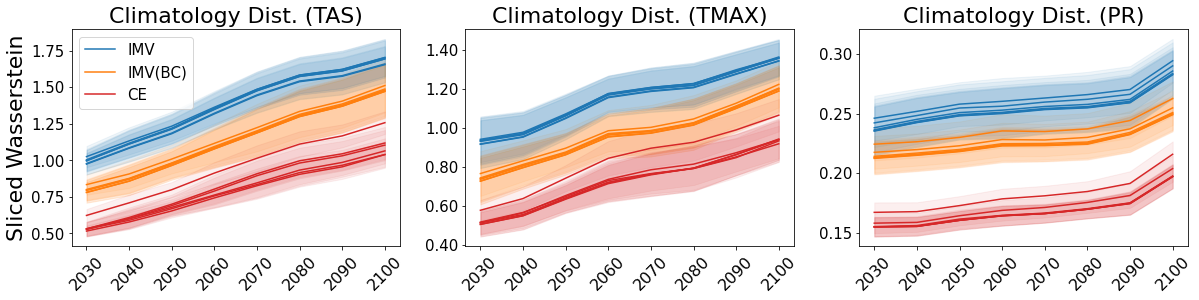

In [11]:
fig, ax = plt.subplots(1, 3, figsize = (20, 4))

analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
years = np.arange(2030, 2110, 10)
s = np.arange(8)

cols = ['C0', 'C1', 'C3']

# labeling
ax[0].set_title('Climatology Dist. (TAS)', fontsize = 22)
ax[1].set_title('Climatology Dist. (TMAX)', fontsize = 22)
ax[2].set_title('Climatology Dist. (PR)', fontsize = 22)

ax[0].set_ylabel('Sliced Wasserstein', fontsize = 22)

ax[0].plot([], [], c = cols[0], label = 'IMV')
ax[0].plot([], [], c = cols[1], label = 'IMV(BC)')
ax[0].plot([], [], c = cols[2], label = 'CE')

for i in range(3):
    for k in range(nproj):

        mean_imv = np.mean(results[i][:,k,0], axis = 0)
        std_imv = np.std(results[i][:,k,0], axis = 0)/np.sqrt(results[i].shape[0])
        lower_imv = mean_imv - 2 * std_imv
        upper_imv = mean_imv + 2 * std_imv

        mean_qc = np.mean(results[i][:,k,1], axis = 0)
        std_qc = np.std(results[i][:,k,1], axis = 0)/np.sqrt(results[i].shape[0])
        lower_qc = mean_qc - 2 * std_qc
        upper_qc = mean_qc + 2 * std_qc

        mean_conf = np.mean(results[i][:,k,2], axis = 0)
        std_conf = np.std(results[i][:,k,2], axis = 0)/np.sqrt(results[i].shape[0])
        lower_conf = mean_conf - 2 * std_conf
        upper_conf = mean_conf + 2 * std_conf

        ax[i].fill_between(s, lower_imv, upper_imv, alpha = 0.07, color = 'C0')
        ax[i].plot(mean_imv.T, c = 'C0')
        ax[i].set_xticks(s, years, fontsize = 16, rotation=45)

        ax[i].fill_between(s, lower_qc, upper_qc, alpha = 0.07, color = 'C1')
        ax[i].plot(mean_qc.T, c = 'C1')

        ax[i].fill_between(s, lower_conf, upper_conf, alpha = 0.07, color = 'C3')
        ax[i].plot(mean_conf.T, c = 'C3')
        
        ax[i].yaxis.set_major_formatter('{x:0<3.2f}')
#         ax[i].xaxis.set_major_formatter('{x:0<3.2f}')
        ax[i].yaxis.set_tick_params(labelsize=15)
    
ax[0].legend(loc = 'upper left', fontsize = 15)
plt.show()

## By month

In [14]:
nproj = 6
nval = 200

xhist_tas = pickle.load(open('../data/xhist_tas_hr.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_tas_hr.pkl', 'rb'))
nmod = xhist_tas.shape[1]
nlat, nlon = xhist_tas[0].shape[1:]

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
xtest_orig = xrcp_tas[108:]

ntrain = xtrain_orig.shape[0] - nval
ntest = xtest_orig.shape[0]

save_loc = 'trained_models/tas'

xtrain_anom, xtest_anom = anomalize(xtrain_orig, xtest_orig)
xtrain_anom = jnp.array(xtrain_anom)
xtest_anom = jnp.array(xtest_anom)
del xtrain_orig, xtest_orig

  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

In [92]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
tas_results = np.zeros([nmod, nproj, 5, 12])
w = slices(nlat, nlon)

weight = jnp.cos(jnp.linspace(math.pi/2 - 1/nlat, -math.pi/2 + 1/nlat, nlat))
weight = weight / jnp.mean(weight)
weight = weight[None,:,None]
weight = np.float32(weight)

for model_no in trange(nmod):
    _data = scale_and_split(xtrain_anom, xtest_anom, model_no = model_no, nval = nval)

    xtrain = _data[0]
    xval = _data[1]
    xtest = _data[2]
    ytrain = _data[3]
    yval = _data[4]
    ytest = _data[5]
    xtrain_mean = _data[6]
    xtest_mean = _data[7]
    xtrain_sd = _data[8]
    xtest_sd = _data[9]

    ntrain = xtrain.shape[0]
    nval = xval.shape[0]
    ntest = xtest.shape[0]

    del _data
    
    for k in trange(0, nproj, leave = False):
        yval_hat = np.load(save_loc + f'/yval_{analysis[k]}_{model_no}.npy')
        yval_hat = yval_hat.reshape(-1, nlat, nlon)
        ytest_hat = np.load(save_loc + f'/ytest_{analysis[k]}_{model_no}.npy')
        ytest_hat = ytest_hat.reshape(-1, nlat, nlon)
        yval_hat = jnp.float32(jnp.array(yval_hat))
        ytest_hat = jnp.float32(jnp.array(ytest_hat))
        
        if analysis[k] == 'lm':
            yval_hat = np.clip(yval_hat, -3, 3)
            ytest_hat = np.clip(ytest_hat, -3, 3)

        xtrain2 = xtrain_sd[:-nval,None] * xtrain + xtrain_mean[:-nval,None]
        ytrain2 = xtrain_sd[:-nval] * ytrain + xtrain_mean[:-nval]

        yval2 = xtrain_sd[-nval:] * yval + xtrain_mean[-nval:]
        yval_hat = xtrain_sd[-nval:] * yval_hat + xtrain_mean[-nval:]

        xtest2 = xtest_sd[:,None] * xtest + xtest_mean[:,None]
        ytest2 = xtest_sd * ytest + xtest_mean
        ytest_hat = xtest_sd * ytest_hat + xtest_mean

        resval = yval2 - yval_hat
        restest = ytest2 - ytest_hat

        imv_ens = xtest2 - ytest_hat[:,None]

        qc_ens = jnp.array([quantile_map(ytrain2[-200:], xtrain2[-200:,j], xtest2[:,j]) for j in range(nmod-1)])
        qc_ens = np.moveaxis(qc_ens, 0, 1)
        qc_ens = qc_ens - ytest_hat[:,None]

        depth_fns = [global_mmd_self, tukey_depth_self, inf_depth]
        conf_ens1 = conformal_ensemble(resval, depth_fns[0], 0.1)
        conf_ens2 = conformal_ensemble(resval, depth_fns[1], 0.1)
        conf_ens3 = conformal_ensemble(resval, depth_fns[2], 0.1)
        
        
        tas_results[model_no, k, 0] = np.array([sw2(imv_ens[i::12], restest[i::12], w) for i in range(12)])
        tas_results[model_no, k, 1] = np.array([sw2(qc_ens[i::12], restest[i::12], w) for i in range(12)])
        tas_results[model_no, k, 2] = np.array([sw2(conf_ens1, restest[i::12], w) for i in range(12)])
        tas_results[model_no, k, 3] = np.array([sw2(conf_ens2, restest[i::12], w) for i in range(12)])
        tas_results[model_no, k, 4] = np.array([sw2(conf_ens3, restest[i::12], w) for i in range(12)])
    

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [15]:
# np.save('./tas_results_mon', tas_results)
tas_results = np.load('./tas_results_mon.npy')

In [94]:
nproj = 6
nval = 200

xhist_tas = pickle.load(open('../data/xhist_tasmax_hr.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_tasmax_hr.pkl', 'rb'))
nmod = xhist_tas.shape[1]
nlat, nlon = xhist_tas[0].shape[1:]

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
xtest_orig = xrcp_tas[108:]

ntrain = xtrain_orig.shape[0] - nval
ntest = xtest_orig.shape[0]

save_loc = 'trained_models/tmax'

xtrain_anom, xtest_anom = anomalize(xtrain_orig, xtest_orig)
xtrain_anom = jnp.array(xtrain_anom)
xtest_anom = jnp.array(xtest_anom)
del xtrain_orig, xtest_orig

  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/924 [00:00<?, ?it/s]

In [95]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
tmax_results = np.zeros([nmod, nproj, 5, 12])
w = slices(nlat, nlon)

weight = jnp.cos(jnp.linspace(math.pi/2 - 1/nlat, -math.pi/2 + 1/nlat, nlat))
weight = weight / jnp.mean(weight)
weight = weight[None,:,None]
weight = np.float32(weight)

for model_no in trange(nmod):
    _data = scale_and_split(xtrain_anom, xtest_anom, model_no = model_no, nval = nval)

    xtrain = _data[0]
    xval = _data[1]
    xtest = _data[2]
    ytrain = _data[3]
    yval = _data[4]
    ytest = _data[5]
    xtrain_mean = _data[6]
    xtest_mean = _data[7]
    xtrain_sd = _data[8]
    xtest_sd = _data[9]

    ntrain = xtrain.shape[0]
    nval = xval.shape[0]
    ntest = xtest.shape[0]

    del _data
    
    for k in trange(0, nproj, leave = False):
        yval_hat = np.load(save_loc + f'/yval_{analysis[k]}_{model_no}.npy')
        yval_hat = yval_hat.reshape(-1, nlat, nlon)
        ytest_hat = np.load(save_loc + f'/ytest_{analysis[k]}_{model_no}.npy')
        ytest_hat = ytest_hat.reshape(-1, nlat, nlon)
        yval_hat = jnp.float32(jnp.array(yval_hat))
        ytest_hat = jnp.float32(jnp.array(ytest_hat))
        
        if analysis[k] == 'lm':
            yval_hat = np.clip(yval_hat, -3, 3)
            ytest_hat = np.clip(ytest_hat, -3, 3)

        xtrain2 = xtrain_sd[:-nval,None] * xtrain + xtrain_mean[:-nval,None]
        ytrain2 = xtrain_sd[:-nval] * ytrain + xtrain_mean[:-nval]

        yval2 = xtrain_sd[-nval:] * yval + xtrain_mean[-nval:]
        yval_hat = xtrain_sd[-nval:] * yval_hat + xtrain_mean[-nval:]

        xtest2 = xtest_sd[:,None] * xtest + xtest_mean[:,None]
        ytest2 = xtest_sd * ytest + xtest_mean
        ytest_hat = xtest_sd * ytest_hat + xtest_mean

        resval = yval2 - yval_hat
        restest = ytest2 - ytest_hat

        imv_ens = xtest2 - ytest_hat[:,None]

        qc_ens = jnp.array([quantile_map(ytrain2[-200:], xtrain2[-200:,j], xtest2[:,j]) for j in range(nmod-1)])
        qc_ens = np.moveaxis(qc_ens, 0, 1)
        qc_ens = qc_ens - ytest_hat[:,None]

        depth_fns = [global_mmd_self, tukey_depth_self, inf_depth]
        conf_ens1 = conformal_ensemble(resval, depth_fns[0], 0.1)
        conf_ens2 = conformal_ensemble(resval, depth_fns[1], 0.1)
        conf_ens3 = conformal_ensemble(resval, depth_fns[2], 0.1)
        
        tmax_results[model_no, k, 0] = np.array([sw2(imv_ens[i::12], restest[i::12], w) for i in range(12)])
        tmax_results[model_no, k, 1] = np.array([sw2(qc_ens[i::12], restest[i::12], w) for i in range(12)])
        tmax_results[model_no, k, 2] = np.array([sw2(conf_ens1, restest[i::12], w) for i in range(12)])
        tmax_results[model_no, k, 3] = np.array([sw2(conf_ens2, restest[i::12], w) for i in range(12)])
        tmax_results[model_no, k, 4] = np.array([sw2(conf_ens3, restest[i::12], w) for i in range(12)])

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [16]:
# np.save('./tmax_results_mon', tmax_results)
tmax_results = np.load('./tmax_results_mon.npy')

In [97]:
nproj = 6
nval = 200

xhist_tas = pickle.load(open('../data/xhist_pr_hr.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_pr_hr.pkl', 'rb'))
nmod = xhist_tas.shape[1]
nlat, nlon = xhist_tas[0].shape[1:]

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
xtest_orig = xrcp_tas[108:]

ntrain = xtrain_orig.shape[0] - nval
ntest = xtest_orig.shape[0]

xtrain_orig = np.log(np.abs(xtrain_orig) + 1e-3)
xtest_orig = np.log(np.abs(xtest_orig) + 1e-3)

xtrain_orig = np.float32(xtrain_orig)
xtest_orig = np.float32(xtest_orig)

save_loc = 'trained_models/pr'

xtrain_anom, xtest_anom = anomalize(xtrain_orig, xtest_orig)
xtrain_anom = np.array(xtrain_anom)
xtest_anom = np.array(xtest_anom)
del xtrain_orig, xtest_orig

  0%|          | 0/1008 [00:00<?, ?it/s]

  0%|          | 0/912 [00:00<?, ?it/s]

In [98]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
pr_results = np.zeros([nmod, nproj, 5, 12])
w = slices(nlat, nlon)

weight = jnp.cos(jnp.linspace(math.pi/2 - 1/nlat, -math.pi/2 + 1/nlat, nlat))
weight = weight / jnp.mean(weight)
weight = weight[None,:,None]
weight = np.float32(weight)

for model_no in trange(nmod):
    _data = scale_and_split(xtrain_anom, xtest_anom, model_no = model_no, nval = nval)

    xtrain = _data[0]
    xval = _data[1]
    xtest = _data[2]
    ytrain = _data[3]
    yval = _data[4]
    ytest = _data[5]
    xtrain_mean = _data[6]
    xtest_mean = _data[7]
    xtrain_sd = _data[8]
    xtest_sd = _data[9]

    ntrain = xtrain.shape[0]
    nval = xval.shape[0]
    ntest = xtest.shape[0]

    del _data
    
    for k in trange(0, nproj, leave = False):
        yval_hat = np.load(save_loc + f'/yval_{analysis[k]}_{model_no}.npy')
        yval_hat = yval_hat.reshape(-1, nlat, nlon)
        ytest_hat = np.load(save_loc + f'/ytest_{analysis[k]}_{model_no}.npy')
        ytest_hat = ytest_hat.reshape(-1, nlat, nlon)
        yval_hat = jnp.float32(jnp.array(yval_hat))
        ytest_hat = jnp.float32(jnp.array(ytest_hat))
        
        if analysis[k] == 'lm':
            yval_hat = np.clip(yval_hat, -3, 3)
            ytest_hat = np.clip(ytest_hat, -3, 3)

        xtrain2 = xtrain_sd[:-nval,None] * xtrain + xtrain_mean[:-nval,None]
        ytrain2 = xtrain_sd[:-nval] * ytrain + xtrain_mean[:-nval]

        yval2 = xtrain_sd[-nval:] * yval + xtrain_mean[-nval:]
        yval_hat = xtrain_sd[-nval:] * yval_hat + xtrain_mean[-nval:]

        xtest2 = xtest_sd[:,None] * xtest + xtest_mean[:,None]
        ytest2 = xtest_sd * ytest + xtest_mean
        ytest_hat = xtest_sd * ytest_hat + xtest_mean

        resval = yval2 - yval_hat
        restest = ytest2 - ytest_hat

        imv_ens = xtest2 - ytest_hat[:,None]

        qc_ens = jnp.array([quantile_map(ytrain2[-200:], xtrain2[-200:,j], xtest2[:,j]) for j in range(nmod-1)])
        qc_ens = np.moveaxis(qc_ens, 0, 1)
        qc_ens = qc_ens - ytest_hat[:,None]

        depth_fns = [global_mmd_self, tukey_depth_self, inf_depth]
        conf_ens1 = conformal_ensemble(resval, depth_fns[0], 0.1)
        conf_ens2 = conformal_ensemble(resval, depth_fns[1], 0.1)
        conf_ens3 = conformal_ensemble(resval, depth_fns[2], 0.1)
        
        pr_results[model_no, k, 0] = np.array([sw2(imv_ens[i::12], restest[i::12], w) for i in range(12)])
        pr_results[model_no, k, 1] = np.array([sw2(qc_ens[i::12], restest[i::12], w) for i in range(12)])
        pr_results[model_no, k, 2] = np.array([sw2(conf_ens1, restest[i::12], w) for i in range(12)])
        pr_results[model_no, k, 3] = np.array([sw2(conf_ens2, restest[i::12], w) for i in range(12)])
        pr_results[model_no, k, 4] = np.array([sw2(conf_ens3, restest[i::12], w) for i in range(12)])
        

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# np.save('./pr_results_mon', pr_results)
pr_results = np.load('./pr_results_mon.npy')

In [18]:
results = [tas_results, tmax_results, pr_results]

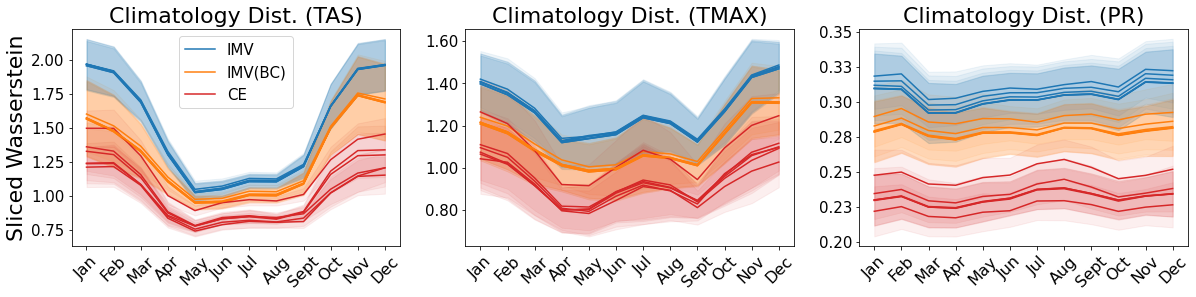

In [23]:
fig, ax = plt.subplots(1, 3, figsize = (20, 4))

analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
ts = np.arange(12)

cols = ['C0', 'C1', 'C3']

# labeling
# ax[0].set_title('Sliced Wassestein - TAS', fontsize = 22)
# ax[1].set_title('Sliced Wassestein - TMAX', fontsize = 22)
# ax[2].set_title('Sliced Wassestein - PR', fontsize = 22)

ax[0].set_title('Climatology Dist. (TAS)', fontsize = 22)
ax[1].set_title('Climatology Dist. (TMAX)', fontsize = 22)
ax[2].set_title('Climatology Dist. (PR)', fontsize = 22)

ax[0].set_ylabel('Sliced Wasserstein', fontsize = 22)

ax[0].plot([], [], c = cols[0], label = 'IMV')
ax[0].plot([], [], c = cols[1], label = 'IMV(BC)')
ax[0].plot([], [], c = cols[2], label = 'CE')

for i in range(3):
    for k in range(nproj):

        mean_imv = np.mean(results[i][:,k,0], axis = 0)
        std_imv = np.std(results[i][:,k,0], axis = 0)/np.sqrt(results[i].shape[0])
        lower_imv = mean_imv - 2 * std_imv
        upper_imv = mean_imv + 2 * std_imv

        mean_qc = np.mean(results[i][:,k,1], axis = 0)
        std_qc = np.std(results[i][:,k,1], axis = 0)/np.sqrt(results[i].shape[0])
        lower_qc = mean_qc - 2 * std_qc
        upper_qc = mean_qc + 2 * std_qc

        mean_conf = np.mean(results[i][:,k,2], axis = 0)
        std_conf = np.std(results[i][:,k,2], axis = 0)/np.sqrt(results[i].shape[0])
        lower_conf = mean_conf - 2 * std_conf
        upper_conf = mean_conf + 2 * std_conf

        ax[i].fill_between(ts, lower_imv, upper_imv, alpha = 0.07, color = 'C0')
        ax[i].plot(mean_imv.T, c = 'C0')
        ax[i].set_xticks(ts, months, fontsize = 16, rotation=45)

        ax[i].fill_between(ts, lower_qc, upper_qc, alpha = 0.07, color = 'C1')
        ax[i].plot(mean_qc.T, c = 'C1')

        ax[i].fill_between(ts, lower_conf, upper_conf, alpha = 0.07, color = 'C3')
        ax[i].plot(mean_conf.T, c = 'C3')
        
        ax[i].yaxis.set_major_formatter('{x:0<3.2f}')
#         ax[i].xaxis.set_major_formatter('{x:0<3.2f}')
        ax[i].yaxis.set_tick_params(labelsize=15)
    
ax[0].legend(loc = 'upper center', fontsize = 15)
plt.show()

## Temperature (TAS)

In [10]:
nproj = 6
nval = 200

xhist_tas = pickle.load(open('../data/xhist_tas_hr.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_tas_hr.pkl', 'rb'))
nmod = xhist_tas.shape[1]

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
xtest_orig = xrcp_tas[108:]

ntrain = xtrain_orig.shape[0] - nval
ntest = xtest_orig.shape[0]

save_loc = 'trained_models/tas'

alpha = 0.1
level = 1 - np.ceil((1 - alpha) * (nval + 1))/(nval + 1)

In [11]:
np.random.seed(0)
nlat, nlon = xhist_tas.shape[2:]
w = np.random.normal(0,1, [500, nlat*nlon])
w = w / np.sqrt(np.sum(w**2, axis = 1))[:,None]

In [12]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
results = np.zeros([nmod, 2 * nproj, 8, 4])

for model_no in trange(nmod):
    xtrain, xval, xtest, ytrain, yval, ytest = scale_and_split(xtrain_orig, xtest_orig, model_no = model_no, nval = nval)
    
    for k in range(0, 2 * nproj, 2):
        
        yval_hat = np.load(save_loc + f'/yval_{analysis[k//2]}_{model_no}.npy')
        ytest_hat = np.load(save_loc + f'/ytest_{analysis[k//2]}_{model_no}.npy')
        
        if analysis[k//2] == 'lm':
            yval_hat = np.clip(yval_hat, -3, 3)
            ytest_hat = np.clip(ytest_hat, -3, 3)
        
        resval = yval - yval_hat.reshape(yval.shape)
        restest = ytest - ytest_hat.reshape(ytest.shape)
        dr1 = global_mmd_self(resval, resval)
        q = np.quantile(dr1, level)

        ## IMV
        imv_ens = np.delete(xtest_orig, model_no, 1)
        imv_ens = imv_ens - np.mean(imv_ens, axis = 1)[:,None,:,:]
        results[model_no, k, :, :-1] = np.array([metrics(imv_ens[(120*i):(120*(i+1))], 
                                                 restest[(120*i):(120*(i+1))]) for i in range(8)])
        results[model_no, k, :, -1] = np.array([sw2(imv_ens[(120*i):(120*(i+1))], 
                                                    restest[(120*i):(120*(i+1))], w) for i in range(8)])

        ## conformal
        conf_ens = resval[dr1 > q]
        results[model_no, k+1, :, :-1] = np.array([metrics(conf_ens, restest[(120*i):(120*(i+1))]) for i in range(8)])
        results[model_no, k+1, :, -1] = np.array([sw2(conf_ens, restest[(120*i):(120*(i+1))], w) for i in range(8)])
    

  0%|          | 0/31 [00:00<?, ?it/s]

In [13]:
tas_results = results

In [14]:
# np.round(np.mean(tas_results, axis = 0), 3)

In [15]:
# for i in range(nmod):
#     plt.plot(tas_results[i,2,:,1], c = 'C0')
    
# for i in range(nmod):
#     plt.plot(tas_results[i,3,:,1], c = 'C1')

In [16]:
# s = np.arange(8)

# mean_imv = np.median(tas_results[:,2,:,1], axis = 0)
# lower_imv = np.quantile(tas_results[:,2,:,1], 0.05, axis = 0)
# upper_imv = np.quantile(tas_results[:,2,:,1], 0.95, axis = 0)

# mean_conf = np.median(tas_results[:,3,:,1], axis = 0)
# lower_conf = np.quantile(tas_results[:,3,:,1], 0.05, axis = 0)
# upper_conf = np.quantile(tas_results[:,3,:,1], 0.95, axis = 0)


# plt.fill_between(s, lower_imv, upper_imv, alpha = 0.1)
# plt.plot(mean_imv, c = 'C0')
# plt.plot(lower_imv, c = 'C0')
# plt.plot(upper_imv, c = 'C0')

# plt.fill_between(s, lower_conf, upper_conf, alpha = 0.1)
# plt.plot(mean_conf, c = 'C1')
# plt.plot(lower_conf, c = 'C1')
# plt.plot(upper_conf, c = 'C1')
# plt.show()

In [17]:
# s = np.arange(8)
# for k in range(0, 2*nproj, 2):
#     if analysis[k//2] != 'lm':
        
#         mean_imv = np.median(tas_results[:,k,:,1], axis = 0)
#         lower_imv = np.quantile(tas_results[:,k,:,1], 0.1, axis = 0)
#         upper_imv = np.quantile(tas_results[:,k,:,1], 0.9, axis = 0)

#         mean_conf = np.median(tas_results[:,k+1,:,1], axis = 0)
#         lower_conf = np.quantile(tas_results[:,k+1,:,1], 0.1, axis = 0)
#         upper_conf = np.quantile(tas_results[:,k+1,:,1], 0.9, axis = 0)


#         plt.fill_between(s, lower_imv, upper_imv, alpha = 0.1, color = 'C0')
#         plt.plot(s, mean_imv, c = 'C0')

#         plt.fill_between(s, lower_conf, upper_conf, alpha = 0.1, color = 'C1')
#         plt.plot(s, mean_conf, c = 'C1')

# plt.plot([],[], c = 'C0', label = 'IMV')
# plt.plot([],[], c = 'C1', label = 'Conf.')
# plt.xlabel('Decade', fontsize = 20)
# plt.ylabel('CRPS', fontsize = 20)
# plt.xticks(s, 2030 + 10*s, fontsize = 12)
# plt.yticks(fontsize = 12)
# plt.legend(fontsize = 15)
# plt.show()

In [18]:
# fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize = (12, 4))

# s = np.arange(8)
# metric = ['CRPS', 'PIT']
# for i in range(2):
#     for k in range(0, 2*nproj, 2):
        
#         if analysis[k//2] != 'lm':

#             mean_imv = np.median(tas_results[:,k,:,i+1], axis = 0)
#             lower_imv = np.quantile(tas_results[:,k,:,i+1], 0.1, axis = 0)
#             upper_imv = np.quantile(tas_results[:,k,:,i+1], 0.9, axis = 0)

#             mean_conf = np.median(tas_results[:,k+1,:,i+1], axis = 0)
#             lower_conf = np.quantile(tas_results[:,k+1,:,i+1], 0.1, axis = 0)
#             upper_conf = np.quantile(tas_results[:,k+1,:,i+1], 0.9, axis = 0)


#             ax[i].fill_between(s, lower_imv, upper_imv, alpha = 0.1, color = 'C0')
#             ax[i].plot(s, mean_imv, c = 'C0')

#             ax[i].fill_between(s, lower_conf, upper_conf, alpha = 0.1, color = 'C1')
#             ax[i].plot(s, mean_conf, c = 'C1')

#     ax[i].plot([],[], c = 'C0', label = 'IMV')
#     ax[i].plot([],[], c = 'C1', label = 'Conf.')
# #     ax[i].set_xlabel('Decade', fontsize = 20)
#     ax[i].set_ylabel(f'{metric[i]}', fontsize = 20)
#     ax[i].set_xticks(s, 2030 + 10*s, fontsize = 12)
# #     ax[i].set_yticks(fontsize = 12)
#     ax[i].legend(fontsize = 15)
# plt.show()

In [19]:
# tas_results.shape

## Temperature Max (TMAX)

In [23]:
nproj = 6
nval = 200

xhist_tas = pickle.load(open('../data/xhist_tasmax_hr.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_tasmax_hr.pkl', 'rb'))
nmod = xhist_tas.shape[1]

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
xtest_orig = xrcp_tas[108:]

ntrain = xtrain_orig.shape[0] - nval
ntest = xtest_orig.shape[0]

save_loc = 'trained_models/tmax'

alpha = 0.1
level = 1 - np.ceil((1 - alpha) * (nval + 1))/(nval + 1)

In [24]:
conf_ens.shape

(180, 90, 180)

In [25]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
results = np.zeros([nmod, 2 * nproj, 8, 4])

for model_no in trange(nmod):
    xtrain, xval, xtest, ytrain, yval, ytest = scale_and_split(xtrain_orig, xtest_orig, model_no = model_no, nval = nval)
    
    for k in range(0, 2 * nproj, 2):
        
        yval_hat = np.load(save_loc + f'/yval_{analysis[k//2]}_{model_no}.npy')
        ytest_hat = np.load(save_loc + f'/ytest_{analysis[k//2]}_{model_no}.npy')
        
        if analysis[k//2] == 'lm':
            yval_hat = np.clip(yval_hat, -3, 3)
            ytest_hat = np.clip(ytest_hat, -3, 3)
        
        resval = yval - yval_hat.reshape(yval.shape)
        restest = ytest - ytest_hat.reshape(ytest.shape)
        dr1 = global_mmd_self(resval, resval)
        q = np.quantile(dr1, level)

        ## IMV
        imv_ens = np.delete(xtest_orig, model_no, 1)
        imv_ens = imv_ens[:,1:] - np.mean(imv_ens, axis = 1)[:,None,:,:]
        results[model_no, k, :, :-1] = np.array([metrics(imv_ens[(120*i):(120*(i+1))], 
                                                         restest[(120*i):(120*(i+1))]) for i in range(8)])
        results[model_no, k, :, -1] = np.array([sw2(imv_ens[(120*i):(120*(i+1))], 
                                                    restest[(120*i):(120*(i+1))], w) for i in range(8)])

        ## conformal
        conf_ens = resval[dr1 > q]
        results[model_no, k+1, :, :-1] = np.array([metrics(conf_ens, restest[(120*i):(120*(i+1))]) for i in range(8)])
        results[model_no, k+1, :, -1] = np.array([sw2(conf_ens, restest[(120*i):(120*(i+1))], w) for i in range(8)])
    

  0%|          | 0/20 [00:00<?, ?it/s]

In [11]:
# i = 3
# restest[(120*i):(120*(i+1))].shape

In [9]:
# metrics(conf_ens, restest[(120*i):(120*(i+1))])

In [10]:
# np.array([metrics(conf_ens, restest[(120*i):(120*(i+1))]) for i in trange(8)]).shape

In [27]:
tmax_results = results

In [ ]:
# np.round(np.mean(tmax_results, axis = 0), 3), np.round(np.std(tmax_results, axis = 0), 3)

## Precipitation (PR)

In [28]:
nproj = 6
nval = 200

xhist_tas = pickle.load(open('../data/xhist_pr_hr.pkl', 'rb'))
xrcp_tas = pickle.load(open('../data/xrcp_pr_hr.pkl', 'rb'))
nmod = xhist_tas.shape[1]

n = (2015 - 1940) * 12
xhist_tas = xhist_tas[-n:]

xtrain_orig = np.concatenate([xhist_tas, xrcp_tas[:108]], axis = 0)
xtest_orig = xrcp_tas[108:]

ntrain = xtrain_orig.shape[0] - nval
ntest = xtest_orig.shape[0]

xtrain_orig = np.log(np.abs(xtrain_orig) + 1e-3)
xtest_orig = np.log(np.abs(xtest_orig) + 1e-3)

save_loc = 'trained_models/pr'

alpha = 0.1
level = 1 - np.ceil((1 - alpha) * (nval + 1))/(nval + 1)

In [30]:
analysis = ['ens', 'wa', 'delta', 'lm', 'nngp', 'cnn1']
results = np.zeros([nmod, 2 * nproj, 8, 4])

for model_no in trange(nmod):
    xtrain, xval, xtest, ytrain, yval, ytest = scale_and_split(xtrain_orig, xtest_orig, model_no = model_no, nval = nval)
    
    for k in range(0, 2 * nproj, 2):
        
        yval_hat = np.load(save_loc + f'/yval_{analysis[k//2]}_{model_no}.npy')
        ytest_hat = np.load(save_loc + f'/ytest_{analysis[k//2]}_{model_no}.npy')
        
        if analysis[k//2] == 'lm':
            yval_hat = np.clip(yval_hat, -3, 3)
            ytest_hat = np.clip(ytest_hat, -3, 3)
        
        resval = yval - yval_hat.reshape(yval.shape)
        restest = ytest - ytest_hat.reshape(ytest.shape)
        dr1 = global_mmd_self(resval, resval)
        q = np.quantile(dr1, level)

        ## IMV
        imv_ens = np.delete(xtest_orig, model_no, 1)[:,1:]
        imv_ens = imv_ens - np.mean(imv_ens, axis = 1)[:,None,:,:]
        results[model_no, k, :, :-1] = np.array([metrics(imv_ens[(120*i):(120*(i+1))], 
                                                 restest[(120*i):(120*(i+1))]) for i in range(8)])
        results[model_no, k, :, -1] = np.array([sw2(imv_ens[(120*i):(120*(i+1))], 
                                                    restest[(120*i):(120*(i+1))], w) for i in range(8)])

        ## conformal
        conf_ens = resval[dr1 > q]
        results[model_no, k+1, :, :-1] = np.array([metrics(conf_ens, restest[(120*i):(120*(i+1))]) for i in range(8)])
        results[model_no, k+1, :, -1] = np.array([sw2(conf_ens, restest[(120*i):(120*(i+1))], w) for i in range(8)])
    

  0%|          | 0/30 [00:00<?, ?it/s]

In [31]:
pr_results = results

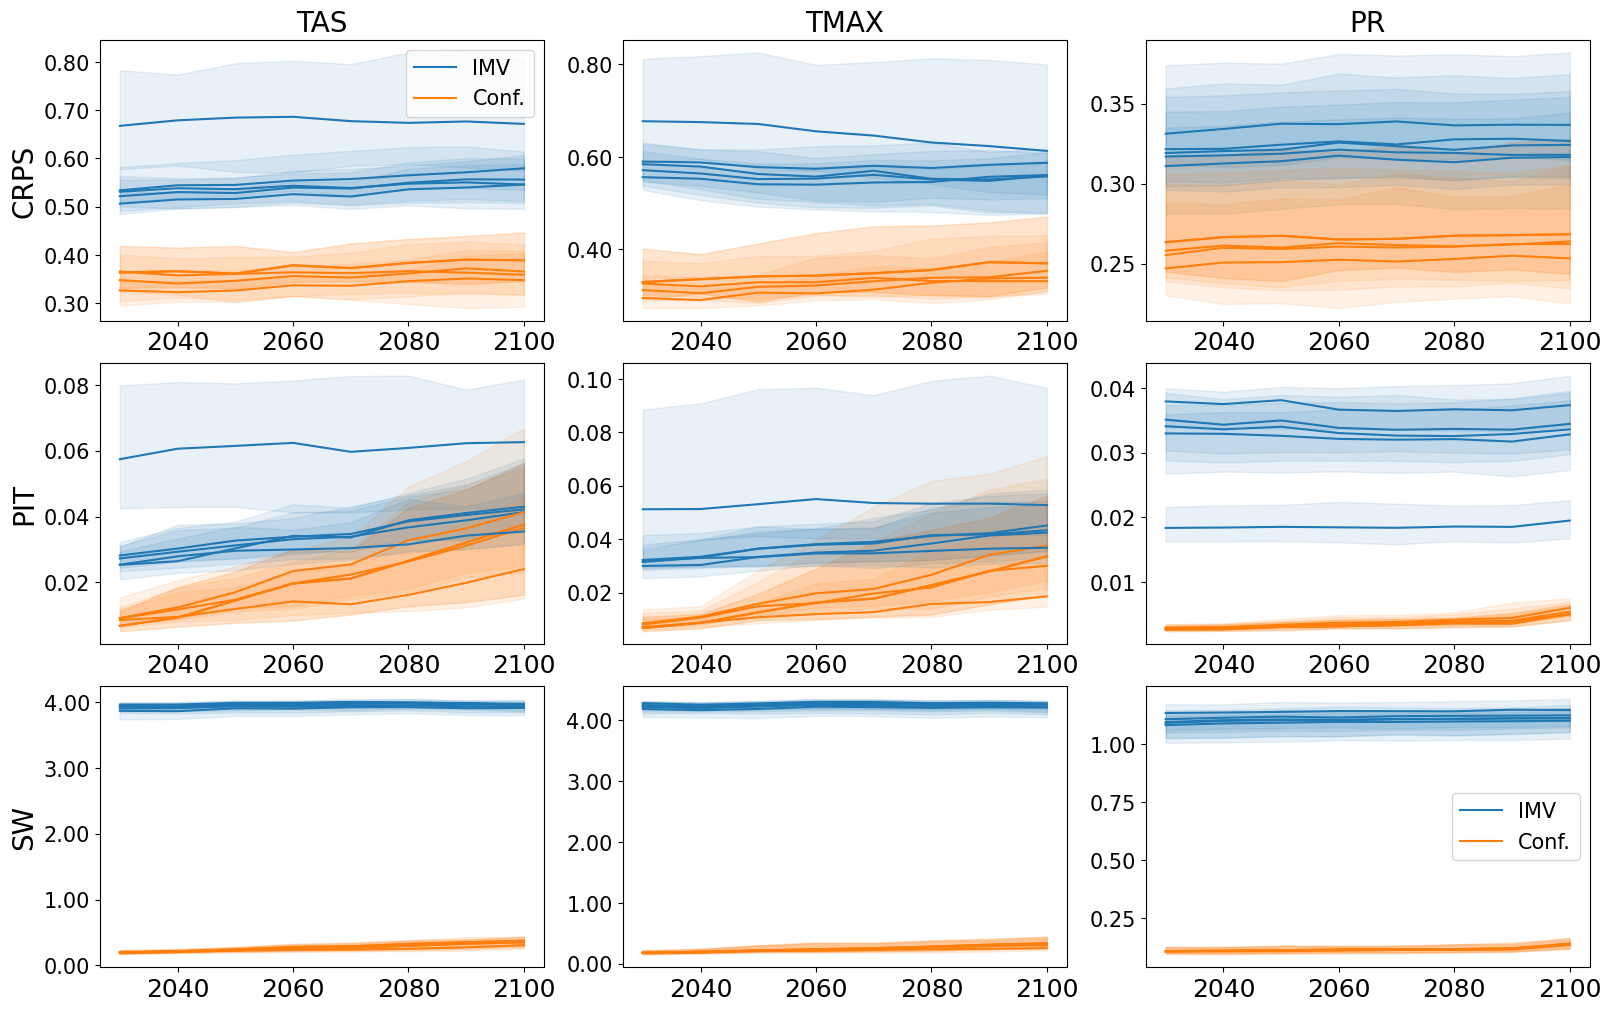

In [60]:
fig, ax = plt.subplots(3, 3, constrained_layout = True, figsize = (16, 10))

s = np.arange(8)
metric = ['CRPS', 'PIT', 'SW']
var_names = ['TAS', 'TMAX', 'PR']
all_results = [tas_results, tmax_results, pr_results]

# Each variable
for i in range(3):
    
    # CRPS vs PIT
    for j in range(3):
        
        # each model
        for k in range(0, 2*nproj, 2):

            if analysis[k//2] != 'lm':

                mean_imv = np.median(all_results[i][:,k,:,j+1], axis = 0)
                lower_imv = np.quantile(all_results[i][:,k,:,j+1], 0.1, axis = 0)
                upper_imv = np.quantile(all_results[i][:,k,:,j+1], 0.9, axis = 0)

                mean_conf = np.median(all_results[i][:,k+1,:,j+1], axis = 0)
                lower_conf = np.quantile(all_results[i][:,k+1,:,j+1], 0.1, axis = 0)
                upper_conf = np.quantile(all_results[i][:,k+1,:,j+1], 0.9, axis = 0)

                ax[j,i].fill_between(s, lower_imv, upper_imv, alpha = 0.1, color = 'C0')
                ax[j,i].plot(s, mean_imv, c = 'C0')

                ax[j,i].fill_between(s, lower_conf, upper_conf, alpha = 0.1, color = 'C1')
                ax[j,i].plot(s, mean_conf, c = 'C1')

        ax[j,i].plot([],[], c = 'C0', label = 'IMV')
        ax[j,i].plot([],[], c = 'C1', label = 'Conf.')
        ax[j,i].xaxis.set_major_formatter('{x:0<3.2f}')
        ax[j,i].yaxis.set_major_formatter('{x:0<3.2f}')
        
        if i == 0:
            ax[j,i].set_ylabel(f'{metric[j]}', fontsize = 20)
        ax[j,i].yaxis.set_tick_params(labelsize=15)
            
        if j == 0:
            ax[j,i].set_title(f'{var_names[i]}', fontsize = 20)
            
        ax[j,i].set_xticks(s[1::2], 2030 + 10 * s[1::2], fontsize = 18)
        
        if (i == 0) and (j == 0):
            ax[j,i].legend(fontsize = 15, loc = 'upper right')
            
        if (i == 2) and (j == 2):
            ax[j,i].legend(fontsize = 15, loc = 'center right')
        
plt.show()

In [45]:
s[1::2]

array([1, 3, 5, 7])

In [ ]:
# np.round(np.mean(pr_results, axis = 0), 3), np.round(np.std(pr_results, axis = 0), 3)

In [ ]:
tas_results2 = np.mean(tas_results, axis = 0)[:,1:]
tmax_results2 = np.mean(tmax_results, axis = 0)[:,1:]
pr_results2 = np.mean(pr_results, axis = 0)[:,1:]

table = np.stack([tas_results2, tmax_results2, pr_results2], axis = 0)
table = np.moveaxis(table, (1, 2), (0, 1)).reshape(12, -1)
table.shape

In [ ]:
fig, ax = plt.subplots(2, 3, constrained_layout = True, figsize = (20, 8))

s = np.arange(8)
metric = ['CRPS', 'PIT']
var_names = ['TAS', 'TMAX', 'PR']
all_results = [tas_results, tmax_results, pr_results]

# Each variable
for i in range(3):
    
    # CRPS vs PIT
    for j in range(2):
        
        # each model
        for k in range(0, 2*nproj, 2):

            if analysis[k//2] != 'lm':

                mean_imv = np.median(all_results[i][:,k,:,j+1], axis = 0)
                lower_imv = np.quantile(all_results[i][:,k,:,j+1], 0.1, axis = 0)
                upper_imv = np.quantile(all_results[i][:,k,:,j+1], 0.9, axis = 0)

                mean_conf = np.median(all_results[i][:,k+1,:,j+1], axis = 0)
                lower_conf = np.quantile(all_results[i][:,k+1,:,j+1], 0.1, axis = 0)
                upper_conf = np.quantile(all_results[i][:,k+1,:,j+1], 0.9, axis = 0)


                ax[j,i].fill_between(s, lower_imv, upper_imv, alpha = 0.1, color = 'C0')
                ax[j,i].plot(s, mean_imv, c = 'C0')

                ax[j,i].fill_between(s, lower_conf, upper_conf, alpha = 0.1, color = 'C1')
                ax[j,i].plot(s, mean_conf, c = 'C1')

        ax[j,i].plot([],[], c = 'C0', label = 'IMV')
        ax[j,i].plot([],[], c = 'C1', label = 'Conf.')
        ax[j,i].set_ylabel(f'{metric[j]}', fontsize = 20)
        ax[j,i].yaxis.set_tick_params(labelsize=18)
        ax[j,i].set_xticks(s[::2], 2020 + 10 * s[::2], fontsize = 18)
        ax[j,i].legend(fontsize = 15, loc = 'upper right')
        
plt.show()